[11:38:52] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=456893;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=968294;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

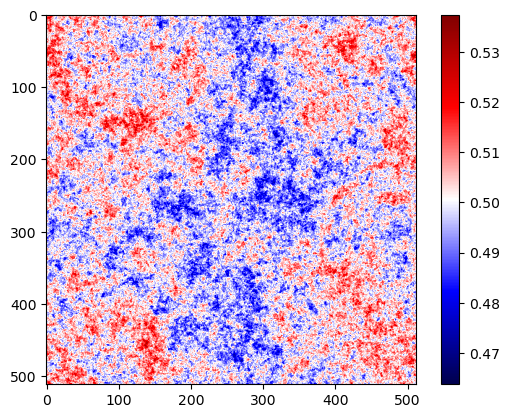

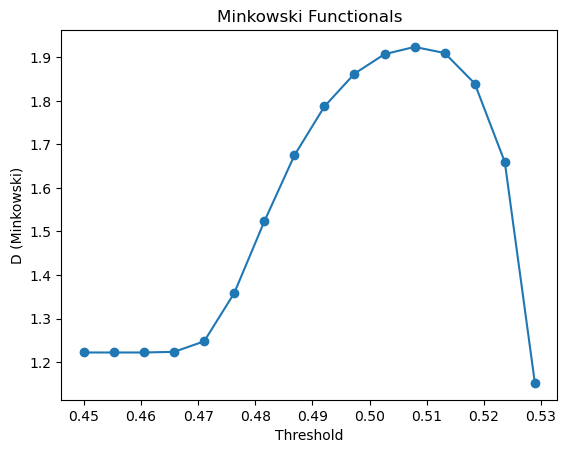

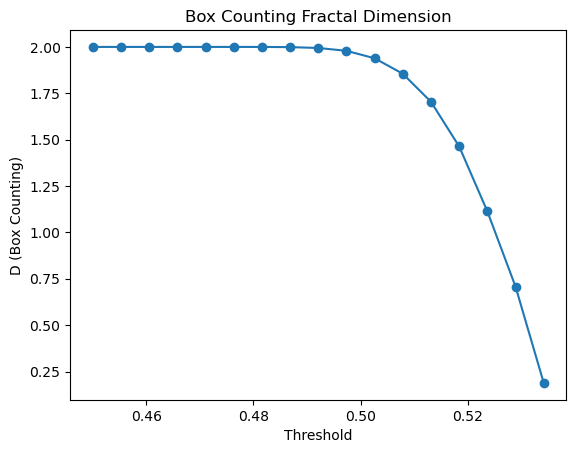

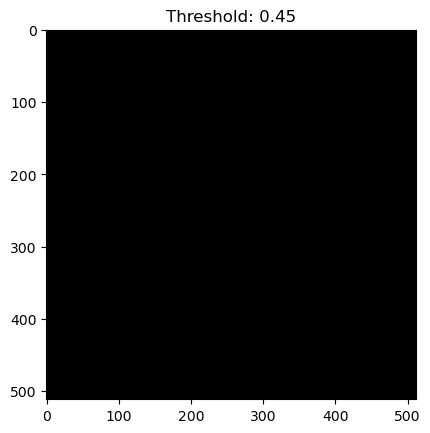

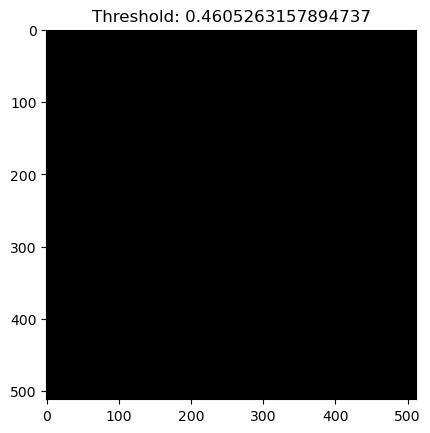

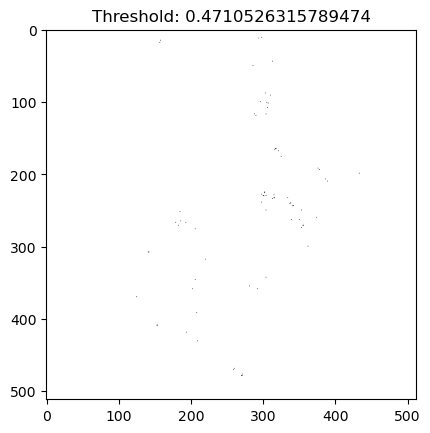

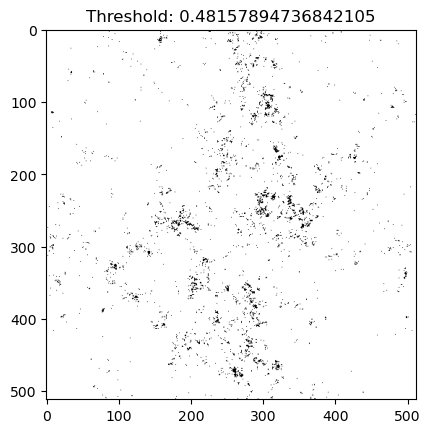

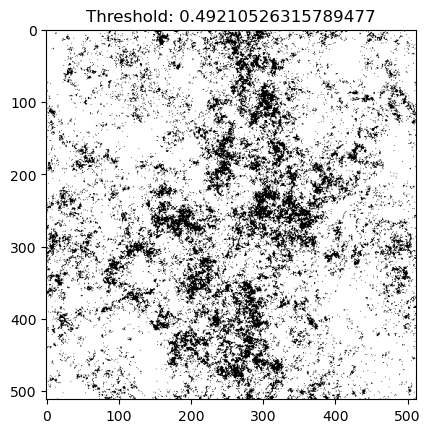

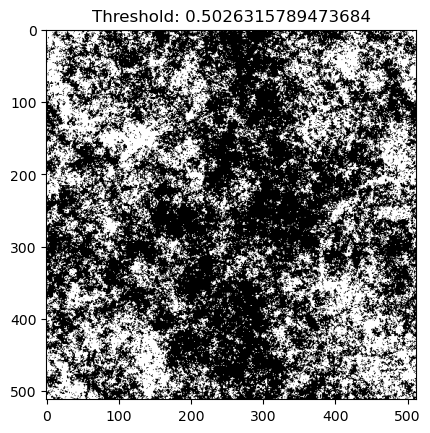

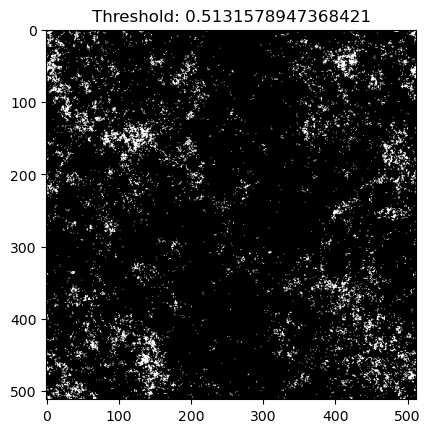

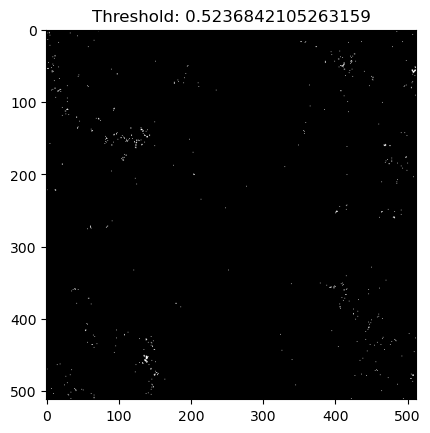

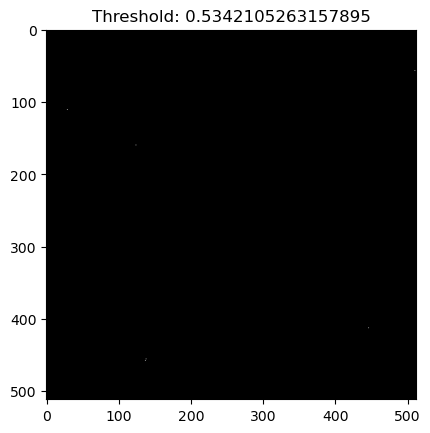

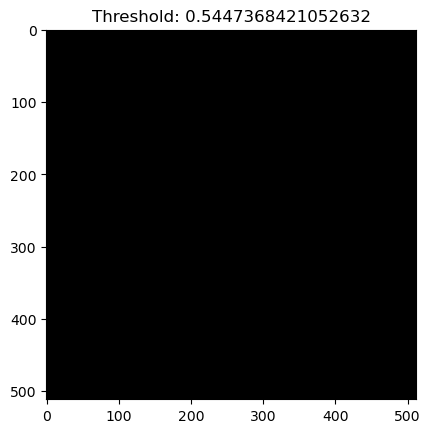

In [1]:
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import perimeter

import porespy as ps

def minkowski_funct(data, thresholds):

    # Store Minkowski Functional values
    areas = []
    perimeters = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1)
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute the euler characteristic
        # For 2D objects, the Euler number is the number of objects minus the number of holes. 

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)
    
    D = 2*log_perimeters/log_areas # proof in Mandelbrot, Hack

    return D

def box_counting_fractal_dimension(img, ):
    """
    Calculate the fractal dimension of a 2D binary image using the box-counting method.

    Parameters:
        img (numpy.ndarray): A 2D binary image where 1 represents the object and 0 represents the background.
        threshold (float): Threshold for binarizing the image if it is not already binary.

    Returns:
        float: The fractal dimension of the image.
    """

    # Sizes of boxes to use (powers of 2)
    sizes = 2 ** np.arange(1, int(np.log2(min(img.shape))) + 1)
    # print(sizes)

    # Count the number of boxes that contain at least one pixel of the object
    box_counts = []

    for size in sizes:
        # Reshape the image to a grid of boxes of size x size
        reshaped_img = img[:img.shape[0] // size * size, :img.shape[1] // size * size]
        reshaped_img = reshaped_img.reshape(reshaped_img.shape[0] // size, size, \
                                            reshaped_img.shape[1] // size, size)
        # Check if any pixel in the box is 1 (object)
        box_count = np.sum(np.any(reshaped_img, axis=(1, 3)))
        box_counts.append(box_count)

    # Log-log plot (log(sizes) vs log(box_counts))
    log_sizes = np.log(1/sizes)
    log_counts = np.log(box_counts)

    # Fit a line to find the slope (fractal dimension)
    slope, _ = np.polyfit(log_sizes, log_counts, 1)

    return slope

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

shape = (512, 512)

field = generate_field(distrib, Pkgen(1.8), shape) + 0.5

plt.imshow(field, cmap="seismic")
plt.colorbar()
plt.show()

thresholds = np.linspace(0.45, 0.55, 20)

D = minkowski_funct(field, thresholds)

plt.plot(thresholds, D, "o-")
plt.xlabel("Threshold")
plt.ylabel("D (Minkowski)")
plt.title("Minkowski Functionals")
plt.show()

fractal_dimensions = []
for threshold in thresholds:

    fractal_dimensions.append(box_counting_fractal_dimension(field >= threshold))

plt.plot(thresholds, fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Box Counting Fractal Dimension')
plt.show()

for i, threshold in enumerate(thresholds):
    if i % 2 == 0:
        plt.imshow(field >= threshold, cmap="gray")
        plt.title(f"Threshold: {threshold}")
        plt.show()


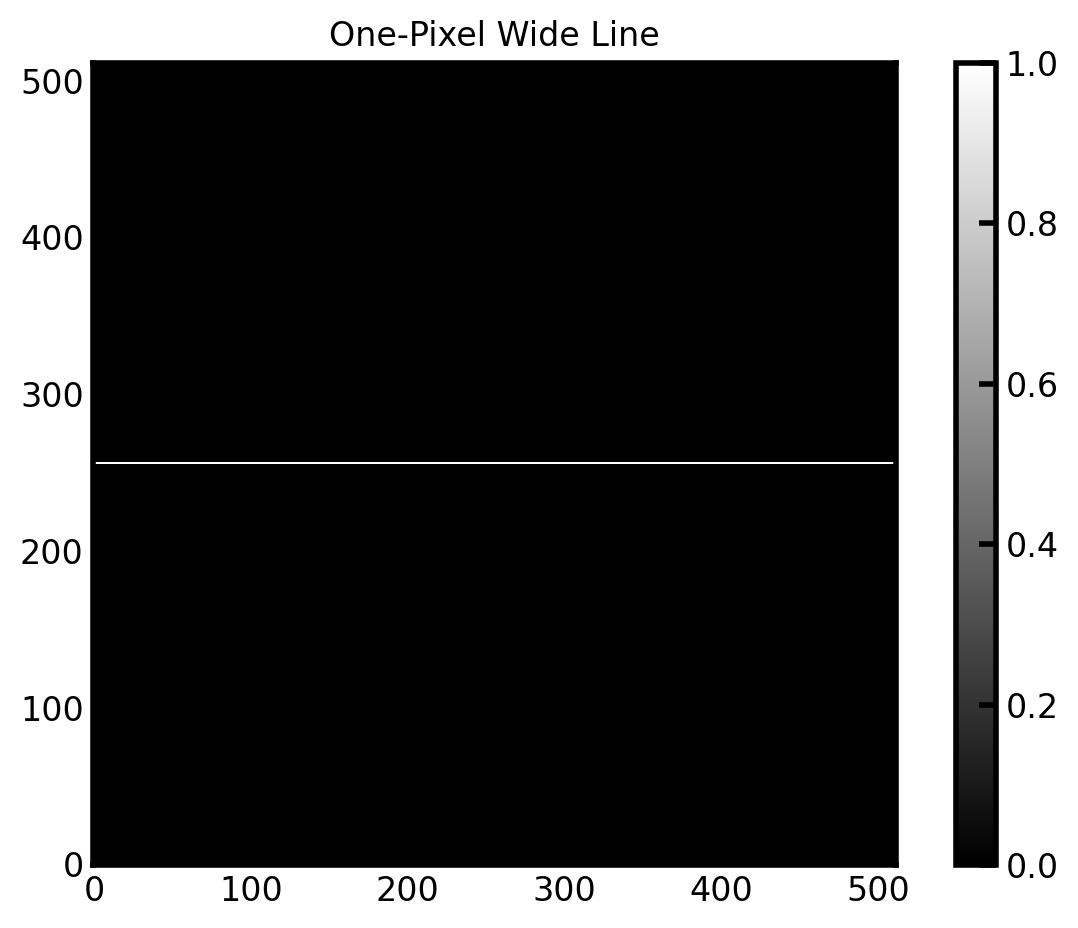

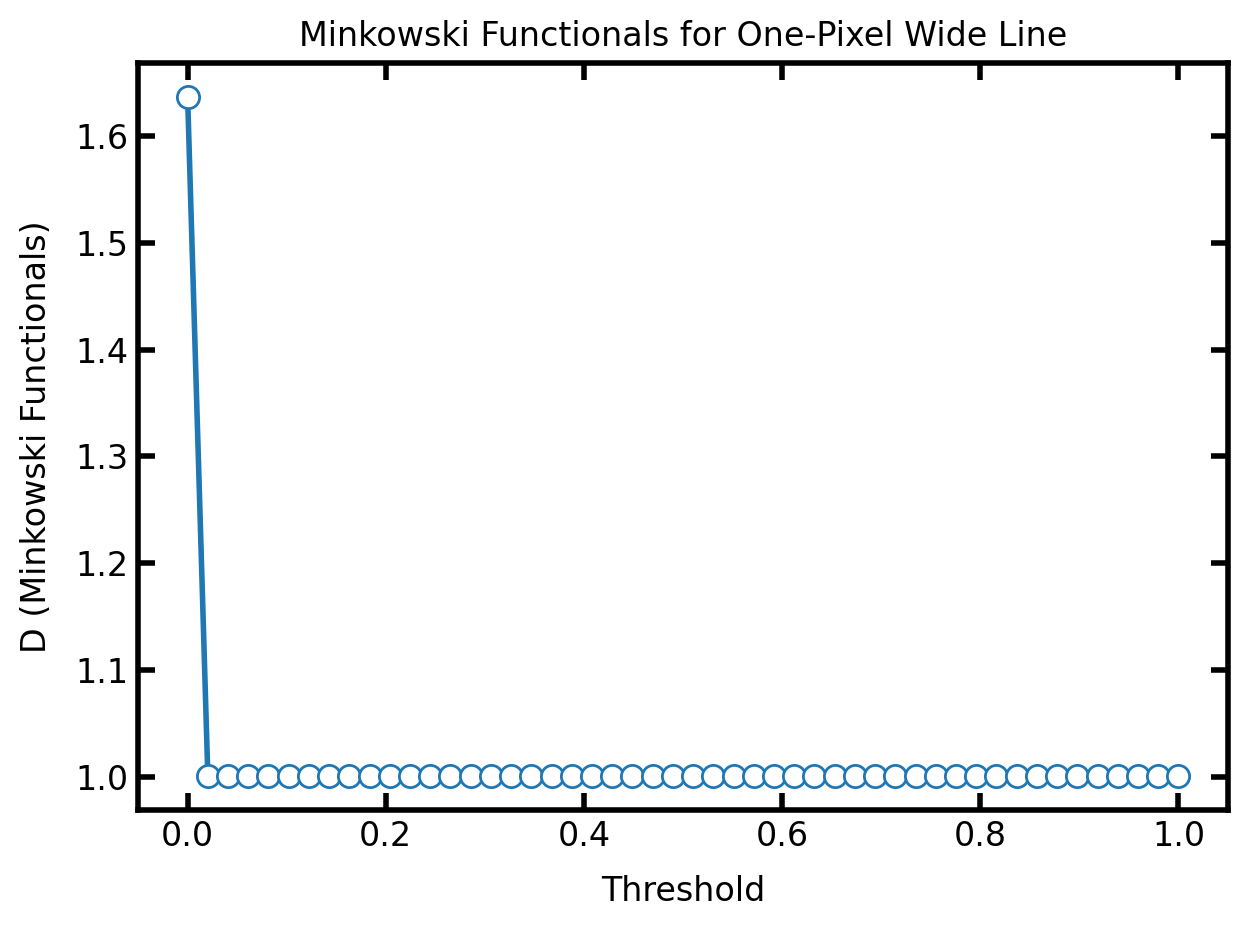

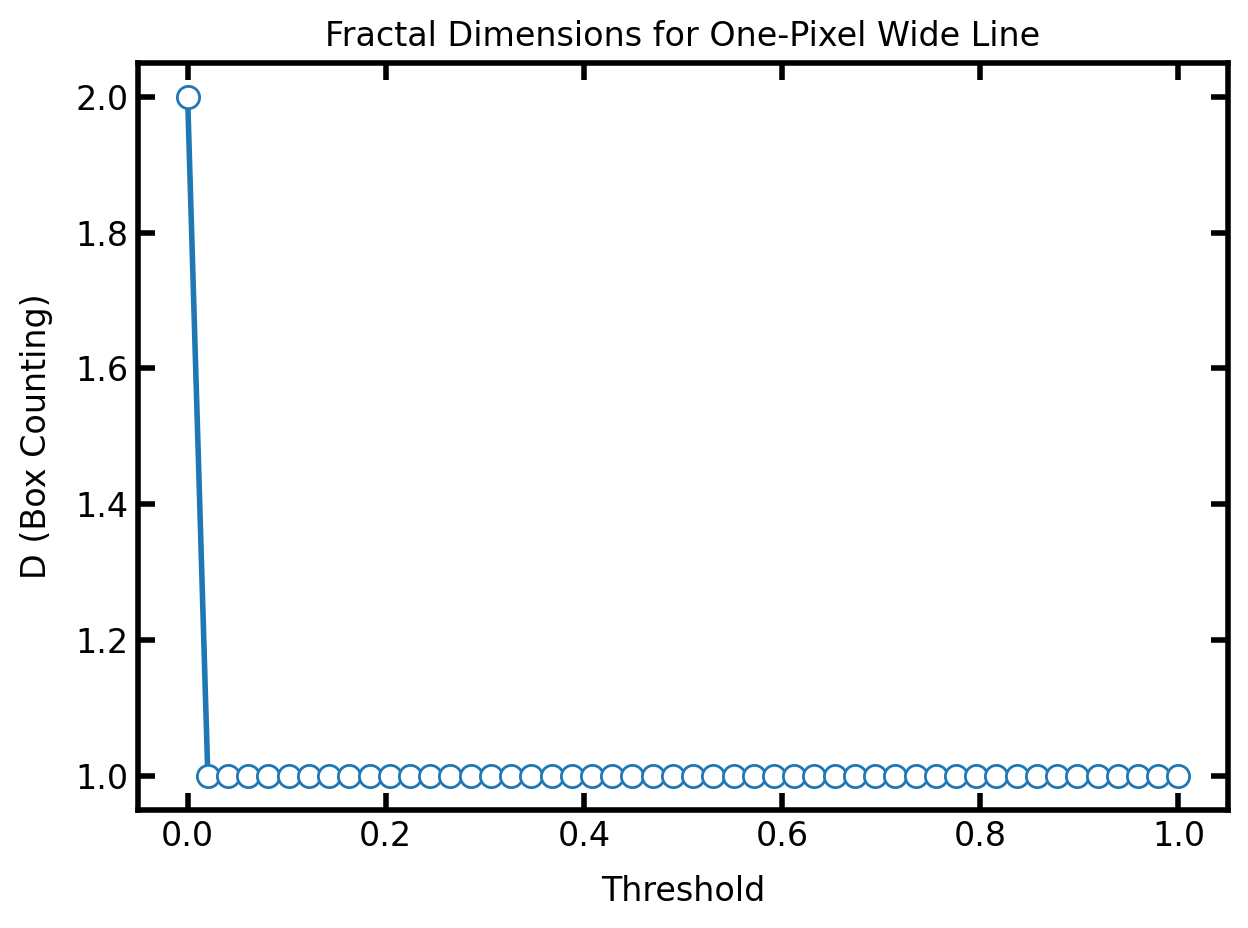

In [14]:
# Create a binary image with a one-pixel wide line
line_image = np.zeros(shape, dtype=bool)
line_image[shape[0] // 2, :] = 1  # Horizontal line in the middle

# Display the line image
plt.imshow(line_image, cmap='gray')
plt.title('One-Pixel Wide Line')
plt.colorbar()
plt.show()

# Calculate Minkowski functionals for the line image
line_thresholds = np.linspace(0, 1, 50)
line_D = minkowski_funct(line_image.astype(float), line_thresholds)

plt.plot(line_thresholds, (2/(line_D)), "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for One-Pixel Wide Line')
plt.show()

# Calculate fractal dimensions using box counting method
line_fractal_dimensions = []
for threshold in line_thresholds:
    line_fractal_dimensions.append(box_counting_fractal_dimension(line_image >= threshold))

plt.plot(line_thresholds, line_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for One-Pixel Wide Line')
plt.show()

In [9]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

# Image Analysis Specific Imports
from skimage.measure import perimeter, euler_number

import porespy as ps
ps.visualization.set_mpl_style()

def remove_region(data, wcs, longitude_min, longitude_max, latitude_min, latitude_max):
    
    min_coord_remove = SkyCoord(longitude_min, latitude_min, frame='galactic', unit=u.deg)
    max_coord_remove = SkyCoord(longitude_max, latitude_max, frame='galactic', unit=u.deg)

    min_pixel_remove = wcs[:][:][0].world_to_pixel(min_coord_remove)
    max_pixel_remove = wcs[:][:][0].world_to_pixel(max_coord_remove)

    # Create a mask based on these galactic coordinates
    remove_mask = np.zeros(data.shape, dtype=bool)

    # Set True in the mask for the specified region based on pixel indices
    y_min, x_min = int(np.floor(min_pixel_remove[1])), int(np.floor(min_pixel_remove[0]))
    y_max, x_max = int(np.ceil(max_pixel_remove[1])), int(np.ceil(max_pixel_remove[0]))

    # Apply the mask to the region within the pixel boundaries
    remove_mask[y_min:y_max, x_max:x_min] = True
    
    # Apply the mask to the original data to set the region to NaN or another value
    data[remove_mask] = np.nan  # Replace with np.nan to exclude the data

    return data

def derive_density_maps():
    # Get the current working directory
    curr_folder = os.getcwd()

    # Find the index of 'notebooks' in the current path
    notebooks_index = curr_folder.rfind('notebooks')

    # Check if 'notebooks' is found in the path
    if notebooks_index != -1:
        # Set the directory to the parent of 'notebooks'
        src_path = os.path.dirname(curr_folder[:notebooks_index])
        os.chdir(src_path)  # Change the current working directory to the source path
        sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports

    # Construct the path to the FITS file
    planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")

    hdu_herschel_fits = fits.open(planck_herschel_fits_file)[0]
    
    # Constructt WCS and image data
    wcs = WCS(hdu_herschel_fits.header)

    image_data = hdu_herschel_fits.data[0]

    # Replace NaNs and Infs with some valid value, e.g., zero or the median
    tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 1: Define constants
    # TO-DO: differentiate between Orion A and B 

    # Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
    # Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

    # Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    # Making it smaller cause of computation time
    # l_min_A, l_max_A = 210, 212
    # b_min_A, b_max_A = -21, -20

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    gamma_orion_A = 2640  # mag
    delta_orion_A = 0.012  # mag, Offset for Orion A

    A_k = gamma_orion_A * tau + delta_orion_A

    A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    gamma_orion_B = 3460  # mag
    delta_orion_B = -0.001  # mag, Offset for Orion B

    A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

    # A_k to A_V
    A_V = A_k/0.112

    # N(H2)
    N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

    # Define regions to remove as a list of dictionaries
    regions_to_remove = [
        # Orion A regions
        {"longitude_min": 208, "longitude_max": 211, "latitude_min": -17.9, "latitude_max": -16.9},
        {"longitude_min": 214.5, "longitude_max": 216.5, "latitude_min": -18, "latitude_max": -17},
        {"longitude_min": 206, "longitude_max": 206.5, "latitude_min": -19.5, "latitude_max": -19},

        # Orion B regions
        {"longitude_min": 208, "longitude_max": 210, "latitude_min": -15, "latitude_max": -12},
        {"longitude_min": 209, "longitude_max": 210, "latitude_min": -16.4, "latitude_max": -15.5},
        {"longitude_min": 203, "longitude_max": 205, "latitude_min": -12.3, "latitude_max": -11.5},
        {"longitude_min": 204.5, "longitude_max": 205.5, "latitude_min": -12.2, "latitude_max": -11.5},
        {"longitude_min": 205.8, "longitude_max": 207, "latitude_min": -13.5, "latitude_max": -12.5},
    ]

    # Loop through each region and remove it from N_H2
    for region in regions_to_remove:
        N_H2 = remove_region(
            N_H2,
            wcs,
            region["longitude_min"],
            region["longitude_max"],
            region["latitude_min"],
            region["latitude_max"]
        )

    
    N_H2_OA = N_H2[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
    N_H2_OB = N_H2[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]

    N_H2 = np.nan_to_num(N_H2, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OA = np.nan_to_num(N_H2_OA, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OB = np.nan_to_num(N_H2_OB, nan=0.0, posinf=0.0, neginf=0.0)
    
    return N_H2, N_H2_OA, N_H2_OB, wcs

    # Kolmogorov turbulence predicts 
    # D = 5/3 (1.7) for turbulent isobar models
    # D = 4/3 (1.3) for turbulent isothermal models

N_H2, N_H2_OA, N_H2_OB, wcs = derive_density_maps()

1.6226483356975787
1.54764772883062
1.4929403902176337
1.4081431570498688
1.3542859789821617
1.2764082119308378
1.175668007254633
1.0694247223589066
0.9253107883215534
0.8215816943653652


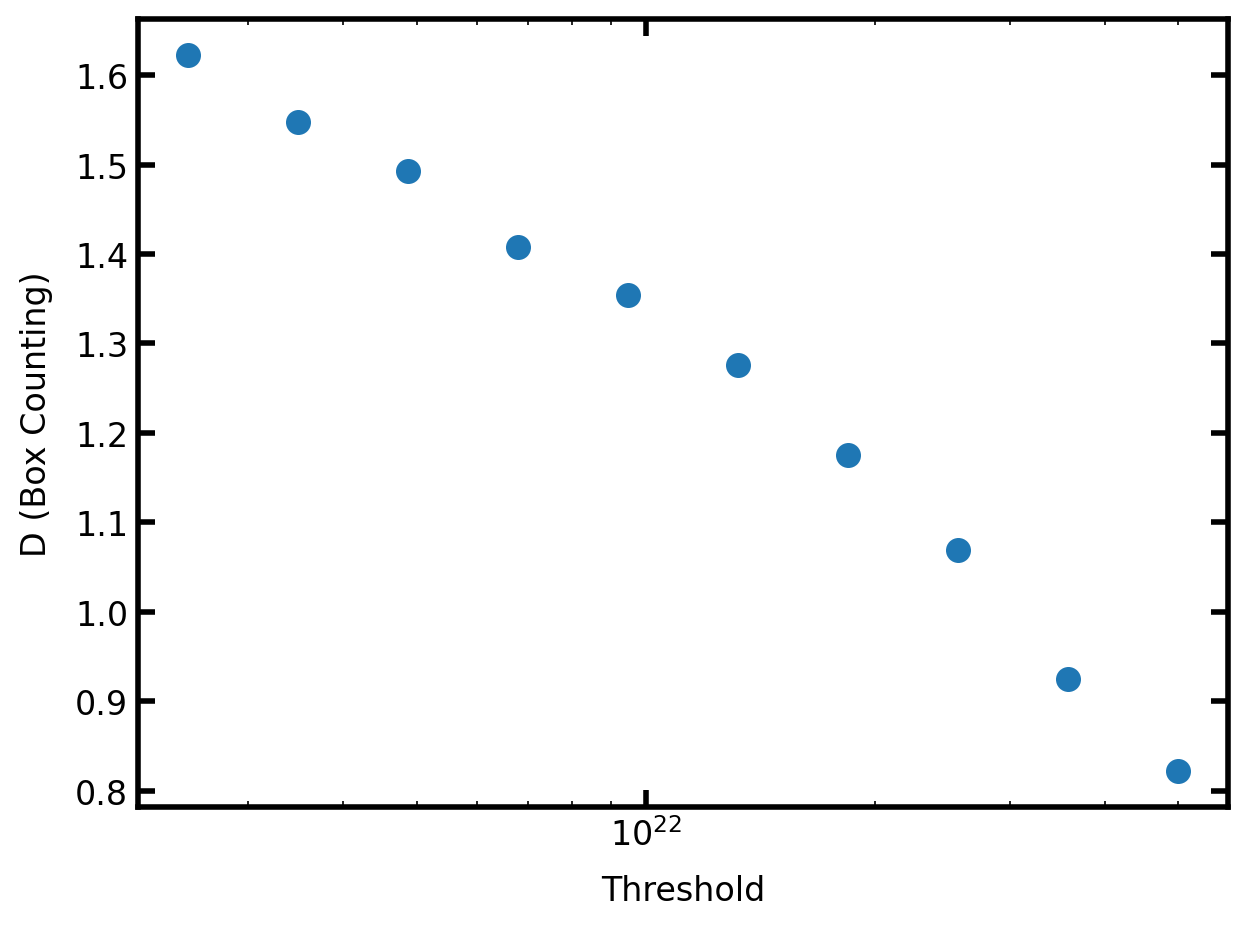

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def box_counting(img, visualize=False):
    """
    Calculate the fractal dimension of a 2D binary image using the box-counting method.

    Parameters:
        img (numpy.ndarray): A 2D binary image where 1 represents the object and 0 represents the background.
        visualize (bool): If True, shows how the image is divided into boxes at each scale.

    Returns:
        float: The fractal dimension of the image.
    """
    # Sizes of boxes to use (powers of 2)
    sizes = 2 ** np.arange(1, int(np.log2(min(img.shape))) + 1)
    
    # Count the number of boxes that contain at least one pixel of the object
    box_counts = []
    
    for size in sizes:
        # Count the number of boxes that contain at least one pixel of the object
        box_count = 0
        for i in range(0, img.shape[0], size):
            for j in range(0, img.shape[1], size):
                if np.any(img[i:i+size, j:j+size]):
                    box_count += 1
        box_counts.append(box_count)
        
        if visualize:
            # Visualize the grid overlay
            plt.figure(figsize=(6, 6))
            plt.imshow(img, cmap='gray', origin='upper')
            
            # Draw grid lines
            for x in range(0, img.shape[1], size):
                plt.axvline(x, color='red', linestyle='--', linewidth=0.5)
            for y in range(0, img.shape[0], size):
                plt.axhline(y, color='red', linestyle='--', linewidth=0.5)
            
            plt.title(f'Box size: {size}x{size}')
            plt.axis('off')
            plt.show()

    # Log-log plot (log(sizes) vs log(box_counts))
    log_sizes = np.log(1/sizes)
    log_counts = np.log(box_counts)

    # Fit a line to find the slope (fractal dimension)
    slope, _ = np.polyfit(log_sizes, log_counts, 1)

    return slope

# Example usage (adjust N_H2_OA to your data)
thresholds = np.logspace(np.log10(2.5e21), np.log10(5e22), 10)

fractal_dimensions = []
for threshold in thresholds:
    mask = N_H2_OA >= threshold

    fractal_dim = box_counting(mask, visualize=False)
    print(fractal_dim)
    fractal_dimensions.append(fractal_dim)

plt.scatter(thresholds, fractal_dimensions)
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.xscale("log")
plt.show()


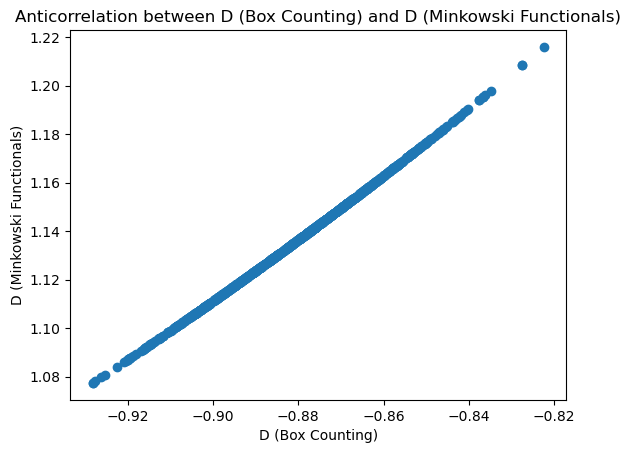

In [7]:
thresholds = np.linspace(0.45, 0.55, 1000)

var1 = np.random.normal(20, 1, 1000) # Area
var2 = np.random.normal(30, 1, 1000) # Perimeter

D_BC = - (np.log10(var1) / np.log10(var2))
D_MF = np.log10(var2) / np.log10(var1)

plt.scatter(D_BC, D_MF)
plt.xlabel("D (Box Counting)")
plt.ylabel("D (Minkowski Functionals)")
plt.title("Anticorrelation between D (Box Counting) and D (Minkowski Functionals)")
plt.show()